<a href="https://colab.research.google.com/github/Olaf-nie-ten-z-frozen/Algorithms/blob/main/OlafTkaczyk_ZadanieZaliczeniowe2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wstęp
Na wstępie należy załadować wszystkie dane i przeanalizować jakie dane są zbyteczne a które mogą prowadzić do błędów(puste dane).

In [773]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

titanic_url = "titanic.csv"
df = pd.read_csv(titanic_url)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Po wstępnej analizie zauważyłem że trzeba usunąć kolumny boat oraz body ponieważ model nauczyłby się przewidywać na podstawie złych danych.


In [774]:
df.isnull().sum()

,0
pclass,0
survived,0
name,0
sex,0
age,263
sibsp,0
parch,0
ticket,0
fare,1
cabin,1014


In [775]:
df = df.drop(['boat', 'body', 'home_dest', 'cabin', 'ticket'], axis=1)


In [776]:
df

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,211.3375,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,151.5500,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,151.5500,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,151.5500,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,151.5500,S
...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,14.4542,C
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,14.4542,C
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,7.2250,C
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,7.2250,C


In [777]:
def extract_title(name):
    if pd.isnull(name):
        return "Unknown"
    return name.split(',')[1].split('.')[0].strip()

df['Title'] = df['name'].apply(extract_title)
#Uzupełnienie wieku na podstawie tytułu
def fill_age(row):
    if pd.isnull(row['age']):
        title_group = df[df['Title'] == row['Title']]
        return title_group['age'].median() if not title_group['age'].isnull().all() else df['age'].median()
    return row['age']

df['age'] = df.apply(fill_age, axis=1)


In [778]:
df.isnull().sum()

,0
pclass,0
survived,0
name,0
sex,0
age,0
sibsp,0
parch,0
fare,1
embarked,2
Title,0


##Pozostałe dane do uzupełnienia (poszczególne pola embarked i fare)

In [779]:
most_common_embarked = df['embarked'].mode()[0] #Zbieramy najczęściej występujące dane
df['embarked'] = df['embarked'].fillna(most_common_embarked)
most_common_fare = df['fare'].mode()[0]
df['fare'] = df['fare'].fillna(most_common_fare)

In [780]:
df.isnull().sum()

,0
pclass,0
survived,0
name,0
sex,0
age,0
sibsp,0
parch,0
fare,0
embarked,0
Title,0


##Teraz tworzymy kategorie dodatkowych danych które będą nam potrzebne do późniejszej ewaluacji age range, family size oraz najważniejsze mpc

In [781]:
df['family_size'] = df['sibsp'] + df['parch'] + 1

def categorize_age(age):
    if age <= 6:
        return 'Baby'
    elif age <= 12:
        return 'Child'
    elif age <= 18:
        return 'Teenager'
    else:
        return 'Adult'

df['age_range'] = df['age'].apply(categorize_age)

df['mpc'] = df['age'] * df['pclass']

df

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked,Title,family_size,age_range,mpc
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,211.3375,S,Miss,1,Adult,29.0000
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,151.5500,S,Master,4,Baby,0.9167
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,151.5500,S,Miss,4,Baby,2.0000
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,151.5500,S,Mr,4,Adult,30.0000
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,151.5500,S,Mrs,4,Adult,25.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,14.4542,C,Miss,2,Teenager,43.5000
1305,3,0,"Zabour, Miss. Thamine",female,22.0000,1,0,14.4542,C,Miss,2,Adult,66.0000
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,7.2250,C,Mr,1,Adult,79.5000
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,7.2250,C,Mr,1,Adult,81.0000


##Aby ułatwić metadane w tabeli uproszczę fare do 'normalnej ceny' z dwoma liczbami po przecinku oraz zamienię 'sex' i 'embarked' na inty dla łatwiejszej analizy

In [782]:
df['fare'] = df['fare'].round(2)
#Zamienienie danych "sex" na 1 i 0 nie daje oczekiwanych wyników
#Kolejne podejście to zamienić te dane na one-hot encoding
#Optymalizacja danych ze string na int z użyciem one-hot encoding
df = pd.get_dummies(df, columns=['sex', 'embarked', 'Title', 'age_range'], dtype='int')
df['age'] = df['age'].astype(int)
print("\nDane po modyfikacjach")
df.info()
df


Dane po modyfikacjach
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pclass              1309 non-null   int64  
 1   survived            1309 non-null   int64  
 2   name                1309 non-null   object 
 3   age                 1309 non-null   int64  
 4   sibsp               1309 non-null   int64  
 5   parch               1309 non-null   int64  
 6   fare                1309 non-null   float64
 7   family_size         1309 non-null   int64  
 8   mpc                 1309 non-null   float64
 9   sex_female          1309 non-null   int64  
 10  sex_male            1309 non-null   int64  
 11  embarked_C          1309 non-null   int64  
 12  embarked_Q          1309 non-null   int64  
 13  embarked_S          1309 non-null   int64  
 14  Title_Capt          1309 non-null   int64  
 15  Title_Col           1309 non-nul

,pclass,survived,name,age,sibsp,parch,fare,family_size,mpc,sex_female,...,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,age_range_Adult,age_range_Baby,age_range_Child,age_range_Teenager
0,1,1,"Allen, Miss. Elisabeth Walton",29,0,0,211.34,1,29.0000,1,...,0,0,0,0,0,0,1,0,0,0
1,1,1,"Allison, Master. Hudson Trevor",0,1,2,151.55,4,0.9167,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,"Allison, Miss. Helen Loraine",2,1,2,151.55,4,2.0000,1,...,0,0,0,0,0,0,0,1,0,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",30,1,2,151.55,4,30.0000,0,...,1,0,0,0,0,0,1,0,0,0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25,1,2,151.55,4,25.0000,1,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",14,1,0,14.45,2,43.5000,1,...,0,0,0,0,0,0,0,0,0,1
1305,3,0,"Zabour, Miss. Thamine",22,1,0,14.45,2,66.0000,1,...,0,0,0,0,0,0,1,0,0,0
1306,3,0,"Zakarian, Mr. Mapriededer",26,0,0,7.22,1,79.5000,0,...,1,0,0,0,0,0,1,0,0,0
1307,3,0,"Zakarian, Mr. Ortin",27,0,0,7.22,1,81.0000,0,...,1,0,0,0,0,0,1,0,0,0


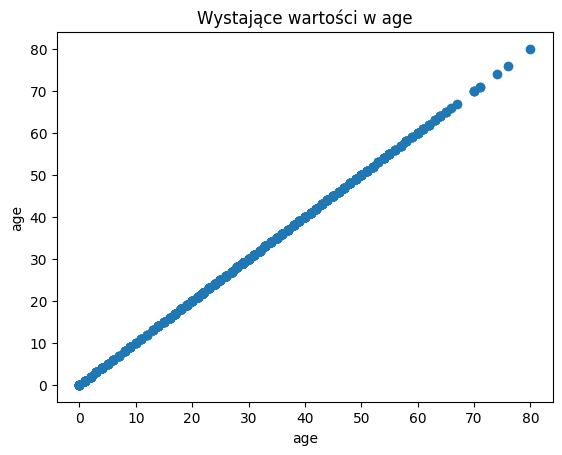

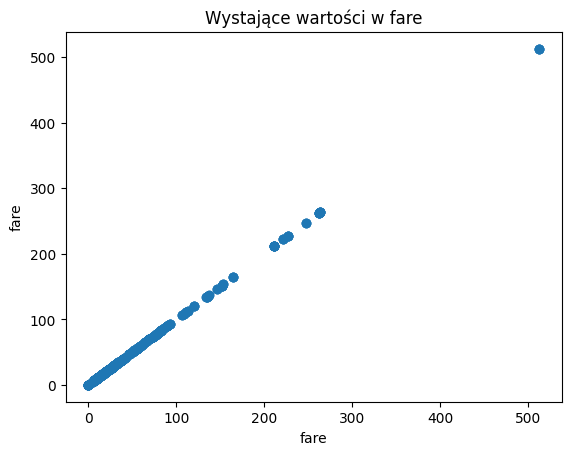

In [783]:
for col in ['age', 'fare']:
    plt.scatter(df[col], df[col])
    plt.title(f"Wystające wartości w {col}")
    plt.xlabel(col)
    plt.ylabel(col)
    plt.show()
    if col == 'age':
        df[col] = np.where((df[col] > 67) | (df[col] < 0), df[col].mean(), df[col])
    elif col == 'fare':
        upper_limit = np.where(df[col] > 300)[0]
        df.loc[upper_limit, col] = df[col].mean()

##W fare jedynymi wartościami wystającymi był fare który przekraczał 300

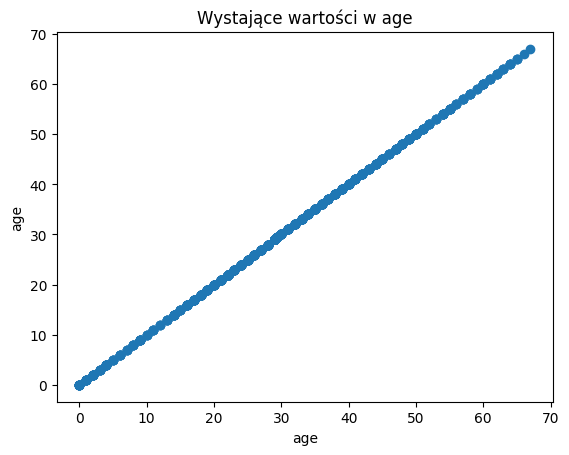

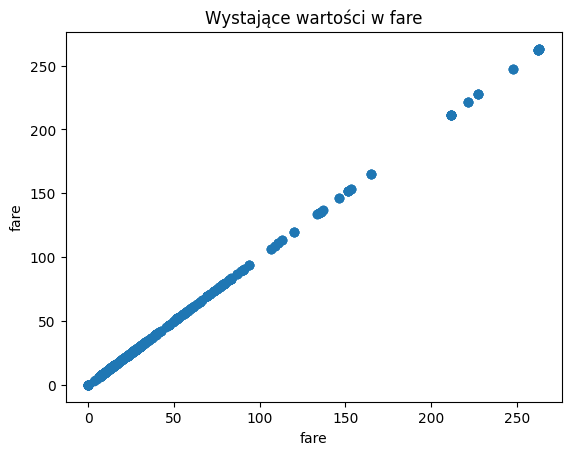

In [784]:
for col in ['age', 'fare']:
    plt.scatter(df[col], df[col])
    plt.title(f"Wystające wartości w {col}")
    plt.xlabel(col)
    plt.ylabel(col)
    plt.show()

In [786]:
#normalizacja z wykorzystaniem MinMaxScalera
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [787]:
df

,pclass,survived,name,age,sibsp,parch,fare,family_size,mpc,sex_female,...,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,age_range_Adult,age_range_Baby,age_range_Child,age_range_Teenager
0,1,1,"Allen, Miss. Elisabeth Walton",0.432836,0,0,0.803574,0.0,0.128668,1,...,0,0,0,0,0,0,1,0,0,0
1,1,1,"Allison, Master. Hudson Trevor",0.000000,1,2,0.576236,0.3,0.001881,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,"Allison, Miss. Helen Loraine",0.029851,1,2,0.576236,0.3,0.006772,1,...,0,0,0,0,0,0,0,1,0,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",0.447761,1,2,0.576236,0.3,0.133182,0,...,1,0,0,0,0,0,1,0,0,0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0.373134,1,2,0.576236,0.3,0.110609,1,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",0.208955,1,0,0.054943,0.1,0.194131,1,...,0,0,0,0,0,0,0,0,0,1
1305,3,0,"Zabour, Miss. Thamine",0.328358,1,0,0.054943,0.1,0.295711,1,...,0,0,0,0,0,0,1,0,0,0
1306,3,0,"Zakarian, Mr. Mapriededer",0.388060,0,0,0.027452,0.0,0.356659,0,...,1,0,0,0,0,0,1,0,0,0
1307,3,0,"Zakarian, Mr. Ortin",0.402985,0,0,0.027452,0.0,0.363431,0,...,1,0,0,0,0,0,1,0,0,0


#Teraz najważniejsza część... Uczenie modelu


 Dokładność: 0.8244274809160306

 Klasyfikacja:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       161
           1       0.81      0.71      0.76       101

    accuracy                           0.82       262
   macro avg       0.82      0.80      0.81       262
weighted avg       0.82      0.82      0.82       262



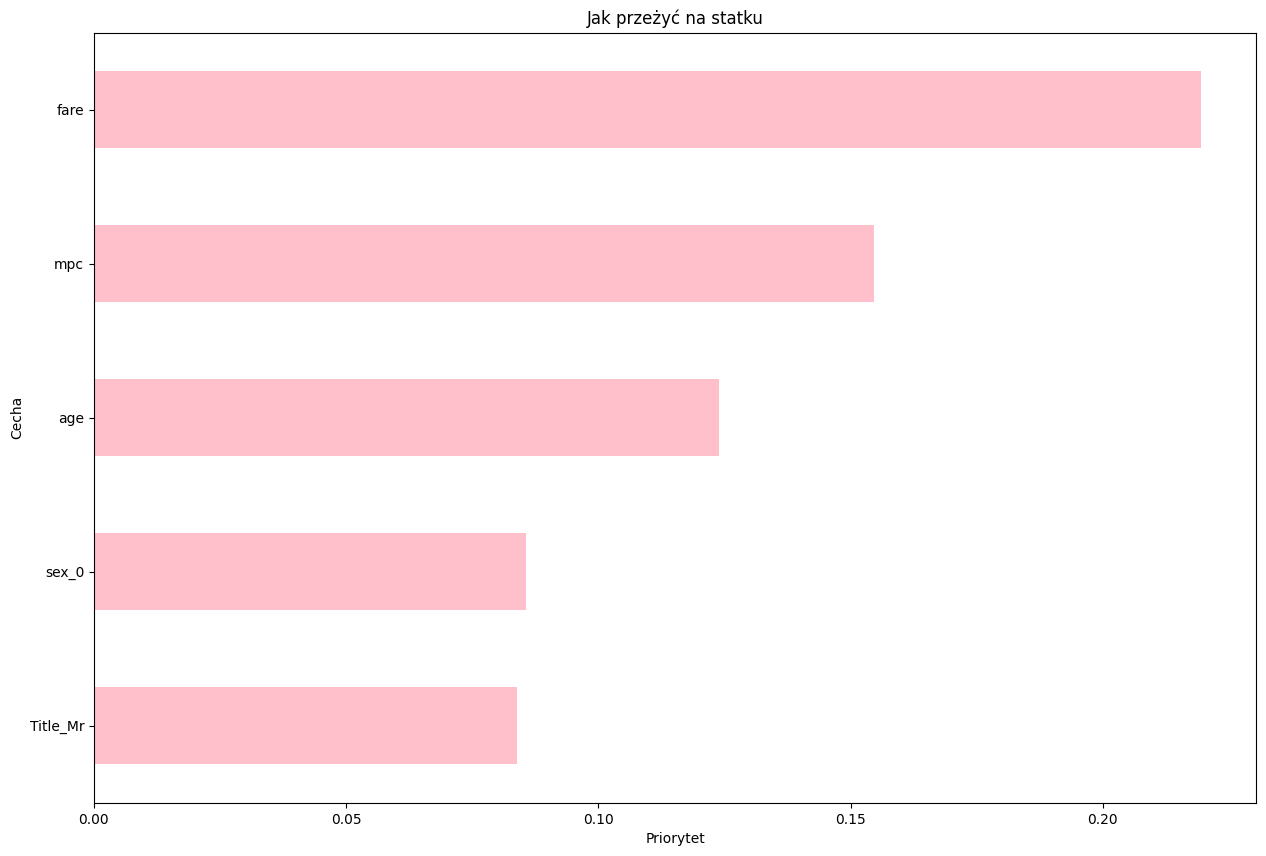

In [788]:
target = 'survived'
predictors = df.drop(columns=['survived', 'name'])
predictors = ['sex', 'age', 'age_range', 'pclass', 'fare']


y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

model = RandomForestClassifier(random_state=12)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\n Dokładność:", accuracy)
print("\n Klasyfikacja:")
print(classification_report(y_test, y_pred))

#Sortowanie danych na podstawie tego jak ważne były
plt.figure(figsize=(15, 10))
feature_importances.head(5).plot(kind='barh', color='pink')
plt.title("Jak przeżyć na statku")
plt.xlabel("Priorytet")
plt.ylabel("Cecha")
plt.gca().invert_yaxis()
plt.show()

In [789]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', random_state=777)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("\nDokladność SVM:", svm_accuracy)
print("\nSVM Klasyfikacja:")
print(classification_report(y_test, y_pred_svm))



Dokladność SVM: 0.8358778625954199

SVM Klasyfikacja:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       161
           1       0.80      0.76      0.78       101

    accuracy                           0.84       262
   macro avg       0.83      0.82      0.83       262
weighted avg       0.83      0.84      0.84       262



In [791]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=777)
gb_model.fit(X_train, y_train)

gb_y_pred = gb_model.predict(X_test)

gb_accuracy = accuracy_score(y_test, gb_y_pred)
print("\nDokładność:", gb_accuracy)
print("\nKlasyfikacja Gradientem :")
print(classification_report(y_test, gb_y_pred))


Dokładność: 0.8320610687022901

Klasyfikacja Gradientem :
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       161
           1       0.87      0.66      0.75       101

    accuracy                           0.83       262
   macro avg       0.84      0.80      0.81       262
weighted avg       0.84      0.83      0.83       262

